# Notebook Modeling Explonate Classifier

> Build baseline & enhaneced classification models for exoplanet validation likelihood

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score, balanced_accuracy_score,
                             precision_recall_curve, confusion_matrix, brier_score_loss,
                             classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
import joblib, json, math

sns.set_theme(context = 'notebook', style = 'dark')

In [2]:
# load datasets :)

df = pd.read_csv('data/processed/exoplanets_unified_derived_imputed.csv')
df.head(2)

/tmp/ipykernel_5119/1690564524.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/processed/exoplanets_unified_derived_imputed.csv')


,host_name,planet_name,disposition,orbital_period_days,semi_major_axis_au,eccentricity,inclination_deg,planet_radius_re,planet_radius_rj,planet_mass_me,...,stellar_mass_msun_imp,stellar_mass_msun_was_imputed,stellar_radius_rsun_imp,stellar_radius_rsun_was_imputed,stellar_teff_k_imp,stellar_teff_k_was_imputed,planet_radius_re_imp,planet_radius_re_was_imputed,transit_depth_ppm_imp,transit_depth_ppm_was_imputed
0,K00752.01,NaN,CONFIRMED,9.488036,0.0853,0.0,89.66,2.26,NaN,NaN,...,0.919,False,0.927,False,5455.0,False,2.26,False,615.8,False
1,K00752.02,NaN,CONFIRMED,54.418383,0.2734,0.0,89.57,2.83,NaN,NaN,...,0.919,False,0.927,False,5455.0,False,2.83,False,874.8,False


In [3]:
df['disposition'].value_counts()

disposition
FALSE POSITIVE    5132
CONFIRMED         5054
CANDIDATE         3348
REFUTED             22
Name: count, dtype: int64

In [4]:
# Target Encoding
POSITIVE_SET = {
    'CONFIRMED', 'CANDIDATE'
}

In [5]:
df['disposition_upper'] = df.get('disposition', 'UNKNOWN').fillna('UNKNOWN').str.upper()

y = df['disposition_upper'].apply(lambda v: 1 if v in POSITIVE_SET else 0)
print(f'Positive Rate: {y.mean().round(3)}')
y.value_counts()

Positive Rate: 0.396


disposition_upper
0    12822
1     8402
Name: count, dtype: int64

In [6]:
# Feature selection heuristic
drop_prefixes = ['orbital_period_err', 'planet_radius_re_err', 'transit_depth_err',
                 'stellar_teff_err', 'stellar_radius_err', 'stellar_mass_err']

raw_duplicate = {'planet_eq_temp_k', 'planet_insolation_earth'}

id_like = {'host_name', 'planet_name', 'source_catalog', 'disposition', 'disposition_upper'}

In [7]:
features = []

for c in df.columns:
    if c in id_like:
        continue

    if c in raw_duplicate:
        continue

    if any(c.startswith(p) for p in drop_prefixes):
        continue

    features.append(c)

len(features), features[:15]

(61,
 ['orbital_period_days',
  'semi_major_axis_au',
  'eccentricity',
  'inclination_deg',
  'planet_radius_re',
  'planet_radius_rj',
  'planet_mass_me',
  'planet_mass_mj',
  'planet_density_gcm3',
  'transit_depth_ppm',
  'tansit_duration_hrs',
  'impact_parameter',
  'a_over_rstar',
  'radius_ratio',
  'stellar_teff_k'])

In [8]:
# Separate by numeric vs categorical

numeric_cols = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in features if c not in numeric_cols]

print(f'Numeric {len(numeric_cols)} \tCategorical: {len(categorical_cols)}')
categorical_cols[:10], numeric_cols[:15]

Numeric 60 	Categorical: 1


(['stellar_teff_bin'],
 ['orbital_period_days',
  'semi_major_axis_au',
  'eccentricity',
  'inclination_deg',
  'planet_radius_re',
  'planet_radius_rj',
  'planet_mass_me',
  'planet_mass_mj',
  'planet_density_gcm3',
  'transit_depth_ppm',
  'tansit_duration_hrs',
  'impact_parameter',
  'a_over_rstar',
  'radius_ratio',
  'stellar_teff_k'])

In [9]:
# one hot encode categorical e.g stellar_teff_bin

low_card_threshold = 12
encoded_parts = []
X_base = pd.DataFrame(index = df.index)

for c in categorical_cols:
    card = df[c].nunique(dropna = True)
    if card <= low_card_threshold:
        dummies = pd.get_dummies(df[c], prefix = c, dummy_na = True)
        encoded_parts.append(dummies)
    else:
        # skip high-card for simplicity, we're working with a simple categorical feat
        pass

if encoded_parts:
    X_cat = pd.concat(encoded_parts, axis = 1)
else:
    X_cat = pd.DataFrame(index = df.index)

X_num = df[numeric_cols].copy()
X = pd.concat([X_num, X_cat], axis = 1)
X.shape


(21224, 66)

In [10]:
# Remove colummns with > 95% constant value

const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
X = X.drop(columns = const_cols)

In [11]:
train_idx, test_idx = train_test_split(X.index, test_size = 0.20, stratify = y, random_state = 32)
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train.shape, X_test.shape

((16979, 65), (4245, 65))

In [12]:
# simple imputer for anyu residual NaN
imp = SimpleImputer(strategy = 'median')
X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test_imp = pd.DataFrame(imp.transform(X_test), columns = X_test.columns, index = X_test.index)
X_train_imp.isna().sum().sum(), X_test_imp.isna().sum().sum()

(np.int64(0), np.int64(0))

In [13]:
# Baseline Model (HistGradiendBoostingClassifier)

hgb = HistGradientBoostingClassifier(random_state = 32)
hgb.fit(X_train_imp, y_train)
prob_test = hgb.predict_proba(X_test_imp)[:,1]
pred_default = (prob_test >= 0.5).astype(int)

metrics_baseline = {
    'roc_auc': roc_auc_score(y_test, prob_test),
    'pr_auc': average_precision_score(y_test, prob_test),
    'balanced_accuracy': balanced_accuracy_score(y_test, pred_default),
    'brier': brier_score_loss(y_test, prob_test)
}

metrics_baseline

{'roc_auc': 0.9811148240972802,
 'pr_auc': 0.9702696466012951,
 'balanced_accuracy': 0.9286950013923698,
 'brier': 0.05278931235640112}

In [14]:
# Confusion matrix (default threshold)

cm = confusion_matrix(y_test, pred_default)
cm_df = pd.DataFrame(cm, index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])
cm_df

,Pred 0,Pred 1
True 0,2387,178
True 1,123,1557


In [15]:
prec, rec, thr = precision_recall_curve(y_test, prob_test)
pr_df = pd.DataFrame({
    'threshold': np.append(thr, np.nan),
    'precision': prec,
    'recall': rec
})

pr_df.head()

,threshold,precision,recall
0,0.000124,0.395760,1.0
1,0.000140,0.395853,1.0
2,0.000141,0.395946,1.0
3,0.000148,0.396040,1.0
4,0.000152,0.396133,1.0


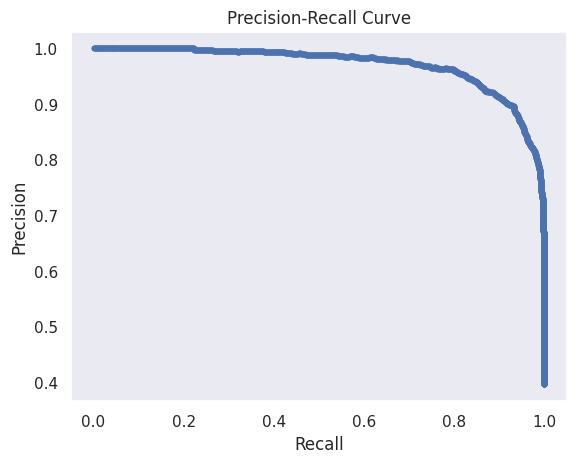

In [16]:
import matplotlib.pyplot as plt

plt.plot(rec, prec, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [33]:
# Threshold optimization: maximize F1 and also get best recall under min precision constraint

def optimize_threshold(precision, recall, thresholds, min_precision = 0.8):
    thresholds_adj = np.append(thresholds, 1.0) # align lengths
    f1 = (2 * precision ** recall) / np.clip(precision + recall, 1e-9, None)
    best_f1_idx = np.nanargmax(f1)
    best_f1 = {
        "strategy": "max_f1",
        "threshold": thresholds_adj[best_f1_idx],
        "precision": float(precision[best_f1_idx]),
        "recall": float(recall[best_f1_idx]),
        "f1": float(f1[best_f1_idx])
    }

    feasible = [
        {
            "threshold": thresholds_adj[i],
            "precision": float(precision[i]),
            "recall": float(recall[i]),
            "f1": float(f1[i])
        }
        for i in range(len(precision)) if precision[i] >= min_precision
    ]

    best_recall = None
    if feasible:
        best_recall = max(feasible, key = lambda d: d["recall"])
        best_recall["strategy"] = f"max_recall_precision>={min_precision}"

    return best_f1, best_recall, feasible

best_f1, best_recall, feasible_list = optimize_threshold(prec, rec, thr, min_precision = 0.85)
best_f1, best_recall

({'strategy': 'max_f1',
  'threshold': np.float64(1.0),
  'precision': 1.0,
  'recall': 0.0,
  'f1': 2.0},
 {'threshold': np.float64(0.3504931180534278),
  'precision': 0.8501059322033898,
  'recall': 0.9553571428571429,
  'f1': 0.9485559583109023,
  'strategy': 'max_recall_precision>=0.85'})

In [34]:
# Apply optimized threshold (fallback to F1 if recall strategy not available)

chosen = best_recall if best_recall else best_f1
thr_opt = chosen['threshold']
y_pred_opt = (prob_test >= thr_opt).astype(int)

opt_metrics = {
    "precision_opt": average_precision_score(y_test, prob_test >= thr_opt),
    "balanced_accuracy_opt": balanced_accuracy_score(y_test, y_pred_opt),
    "threshold": thr_opt
}b

conf_opt = confusion_matrix(y_test, y_pred_opt)
conf_opt

array([[2282,  283],
       [  75, 1605]])

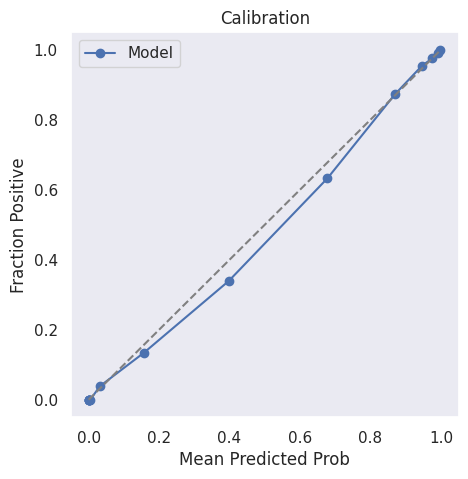

In [35]:
# Calibration curve

frac_pos, mean_pred = calibration_curve(y_test, prob_test, n_bins = 15, strategy = "quantile")
plt.figure(figsize = (5, 5))
plt.plot(mean_pred, frac_pos, marker = 'o', label = 'Model')
plt.plot([0, 1], [0, 1], '--', color = 'gray')
plt.xlabel('Mean Predicted Prob')
plt.ylabel('Fraction Positive')
plt.title('Calibration')
plt.legend()
plt.show()

In [36]:
# Permutation Importance

perm = permutation_importance(hgb, X_test_imp, y_test, n_repeats = 10, random_state = 32, n_jobs = -1)
imp_df = pd.DataFrame({
    "feature": X_test_imp.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending = False)

imp_df.head(20)

,feature,importance_mean,importance_std
9,transit_depth_ppm,0.089941,0.005713
51,stellar_mass_msun_was_imputed,0.067161,0.004240
24,dec_deg,0.037574,0.003728
58,transit_depth_ppm_imp,0.027986,0.001515
12,a_over_rstar,0.015807,0.001774
29,snr_model,0.011779,0.001612
30,snr_single_event,0.010978,0.002551
0,orbital_period_days,0.010695,0.001834
23,ra_deg,0.007562,0.000833
10,tansit_duration_hrs,0.007185,0.001524


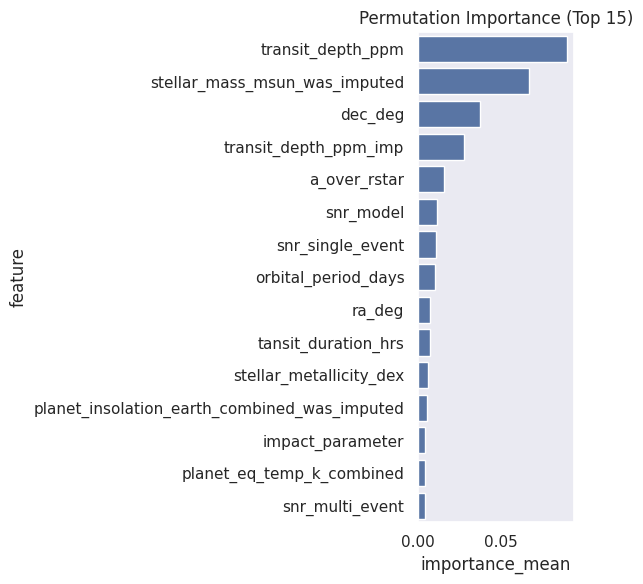

In [37]:
# Plot top 15 importances

top15 = imp_df.head(15)
plt.figure(figsize = (6, 6))
sns.barplot(data = top15, y = "feature", x = "importance_mean", orient = "h")
plt.title("Permutation Importance (Top 15)")
plt.tight_layout()
plt.show()

In [38]:
# Correlation with target (point-biserial approximation for numeric)
from scipy.stats import pointbiserialr

corr_rows = []

for c in X_train_imp.columns:
    s = X_train_imp[c]
    if s.nunique() > 2:
        try:
            r, p = pointbiserialr(s, y_train)
            corr_rows.append({
                "feature": c,
                "pb_corr": r,
                "p_value": p
            })
        except Exception:
            pass

corr_df = pd.DataFrame(corr_rows).sort_values("pb_corr", ascending = False)
corr_df.head(15)

,feature,pb_corr,p_value
42,log_orbital_period,0.203143,1.314912e-157
27,parallax_mas,0.174879,1.098303e-116
16,stellar_metallicity_dex,0.166509,8.162600e-106
3,inclination_deg,0.155423,2.807940e-92
15,stellar_logg_cgs,0.148337,3.907623e-84
23,ra_deg,0.118697,2.525989e-54
24,dec_deg,0.112723,3.896685e-49
2,eccentricity,0.112027,1.503241e-48
5,planet_radius_rj,0.066757,3.100164e-18
25,pm_ra_masyr,0.064159,5.852991e-17


In [40]:
# Error analysis: false positives / false negatives

errors = pd.DataFrame({
    "prob": prob_test,
    "y_true": y_test,
    "y_pred": y_pred_opt
}, index = X_test_imp.index)

fps = errors[(errors.y_true == 0) & (errors.y_pred == 1)].sort_values("prob", ascending = False).head(10)
fns = errors[(errors.y_true == 1) & (errors.y_pred == 0)].sort_values("prob", ascending = True).head(10)

fps, fns

(           prob  y_true  y_pred
 18873  0.993360       0       1
 177    0.990851       0       1
 18306  0.985951       0       1
 785    0.979972       0       1
 20908  0.976065       0       1
 859    0.974409       0       1
 18466  0.972480       0       1
 18869  0.970288       0       1
 3287   0.968963       0       1
 2189   0.966708       0       1,
           prob  y_true  y_pred
 123   0.010296       1       0
 8805  0.011585       1       0
 172   0.014153       1       0
 456   0.015544       1       0
 7949  0.023011       1       0
 6991  0.050141       1       0
 327   0.056762       1       0
 519   0.056843       1       0
 5155  0.057153       1       0
 3368  0.057339       1       0)

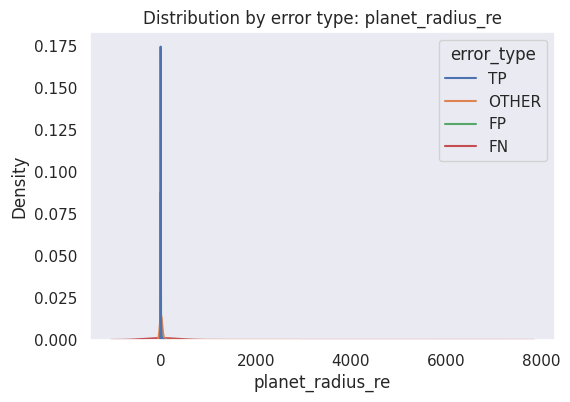

In [41]:
# Feature distributions for FP vs TP (example: planet_radius_re)

feat_focus = 'planet_radius_re'

if feat_focus in X_test_imp.columns:
    tmp = X_test_imp[[feat_focus]].copy()
    tmp["y_true"] = y_test
    tmp["prob"] = prob_test
    tmp["pred"] = y_pred_opt
    tmp["error_type"] = np.select(
        [
            (tmp.y_true == 1) & (tmp.pred == 1),
            (tmp.y_true == 0) & (tmp.pred == 1),
            (tmp.y_true == 1) & (tmp.pred == 0)
        ],
        ["TP", "FP", "FN"],
        default = "OTHER"
    )

    plt.figure(figsize = (6, 4))
    sns.kdeplot(data = tmp, x = feat_focus, hue = "error_type", common_norm = False)
    plt.title(f"Distribution by error type: {feat_focus}")
    plt.show()

In [49]:
# Cross-validation

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 32)
cv_scores = []

for fold, (tr, va) in enumerate(skf.split(X_train_imp, y_train), 1):
    model = HistGradientBoostingClassifier(random_state = fold)
    model.fit(X_train_imp.iloc[tr], y_train.iloc[tr])
    p = model.predict_proba(X_train_imp.iloc[va])[:, 1]

    cv_scores.append({
        "fold": fold,
        "roc_auc": roc_auc_score(y_train.iloc[va], p),
        "pr_auc": average_precision_score(y_train.iloc[va], p)
    })

pd.DataFrame(cv_scores).sort_values('roc_auc', ascending = False)

,fold,roc_auc,pr_auc
6,7,0.982908,0.972505
9,10,0.982758,0.973305
0,1,0.982166,0.972310
7,8,0.981633,0.971938
4,5,0.980720,0.967599
2,3,0.980463,0.969274
3,4,0.979951,0.969460
8,9,0.977844,0.965077
1,2,0.976792,0.963177
5,6,0.976196,0.964730


In [50]:
# Random Forest secondary + simple ensemble

rf = RandomForestClassifier(n_estimators = 600, random_state = 32, n_jobs = -1)
rf.fit(X_train_imp, y_train)
prob_test_rf = rf.predict_proba(X_test_imp)[:, 1]
prob_ens = (prob_test + prob_test_rf) / 2

metrics_ens = {
    "roc_auc": roc_auc_score(y_test, prob_ens),
    "pr_auc": average_precision_score(y_test, prob_ens),
    "brier": brier_score_loss(y_test, prob_ens)
}

metrics_ens

{'roc_auc': 0.982758748723661,
 'pr_auc': 0.9730942100575947,
 'brier': 0.051375627279854785}

In [52]:
# Threshold search on ensemble

prec_e, rec_e, thr_e = precision_recall_curve(y_test, prob_ens)
best_f1_e, best_recall_e, feasible_e = optimize_threshold(prec_e, rec_e, thr_e, min_precision = 0.85)
best_f1_e, best_recall_e

({'strategy': 'max_f1',
  'threshold': np.float64(1.0),
  'precision': 1.0,
  'recall': 0.0,
  'f1': 2.0},
 {'threshold': np.float64(0.3633241996221124),
  'precision': 0.850131926121372,
  'recall': 0.9589285714285715,
  'f1': 0.9461485509522665,
  'strategy': 'max_recall_precision>=0.85'})

In [54]:
# Compare baseline vs ensemble metrics

comparison = {
    "baseline_roc_auc": metrics_baseline["roc_auc"],
    "ensemble_roc_auc": metrics_ens["roc_auc"],
    "baseline_pr_auc": metrics_baseline["pr_auc"],
    "ensemble_pr_auc": metrics_ens["pr_auc"]
}

comparison

{'baseline_roc_auc': 0.9811148240972802,
 'ensemble_roc_auc': 0.982758748723661,
 'baseline_pr_auc': 0.9702696466012951,
 'ensemble_pr_auc': 0.9730942100575947}

In [60]:
ARTIFACT_DIR = './models'

joblib.dump(hgb, f"{ARTIFACT_DIR}/hgb_baseline.pkl")
joblib.dump(rf,  f"{ARTIFACT_DIR}/rf_model.pkl")
joblib.dump(imp, f"{ARTIFACT_DIR}/imputer.pkl")

artifact = {
    "baseline_metrics": metrics_baseline,
    "ensemble_metrics": metrics_ens,
    "best_threshold_baseline": chosen,
    "best_threshold_ensemble": best_recall_e if best_recall_e else best_f1_e,
    "feature_count": len(X.columns),
    "top_importances": imp_df.head(25).to_dict(orient = "records")
}

with open("./models/artifact.json", "w", encoding="utf-8") as f:
    json.dump(artifact, f, indent=2, ensure_ascii=False)

In [61]:
model_card = f"""
                MODEL CARD
-------------------------------------------
Model Types: HistGradientBoosting (baseline), Ensemble(HGB + RF)
Data Source: Unified Exoplanet Catalog (Kepler / TESS / K2) derived + imputed
Positive Definition: disposition in {POSITIVE_SET}
Baseline ROC-AUC:{metrics_baseline['roc_auc']:.3f}
Ensemble ROC-AUC: {metrics_ens['roc_auc']:.3f}
Baseline PR-AUC: {metrics_baseline['pr_auc']:.3f}
Ensemble PR-AUC: {metrics_ens['pr_auc']:.3f}
Optiomal Threshold (baseline): {chosen['threshold']:.4f}
Feature Count: {len(X.columns)}
Notes: Calibration not explicitly applied; consider isotonic fitting for production :)
"""

print(model_card)


                MODEL CARD
-------------------------------------------
Model Types: HistGradientBoosting (baseline), Ensemble(HGB + RF)
Data Source: Unified Exoplanet Catalog (Kepler / TESS / K2) derived + imputed
Positive Definition: disposition in {'CANDIDATE', 'CONFIRMED'}
Baseline ROC-AUC:0.981
Ensemble ROC-AUC: 0.983
Baseline PR-AUC: 0.970
Ensemble PR-AUC: 0.973
Optiomal Threshold (baseline): 0.3505
Feature Count: 65
Notes: Calibration not explicitly applied; consider isotonic fitting for production :)

